In [29]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import pickle



import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import aa598.hw1_helper as hw1_helper


from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False) # set to False if latex is not set up on your computer
wave_data_training = "D:/AA598-aut24/homework/data/hw1/wave_data_train.pickle"
wave_data_multimodal = "D:/AA598-aut24/homework/data/hw1/multimodal_data_test.pickle"
wave_data_test = "homework/data/hw1/wave_data_test.pickle"

## Visualize data

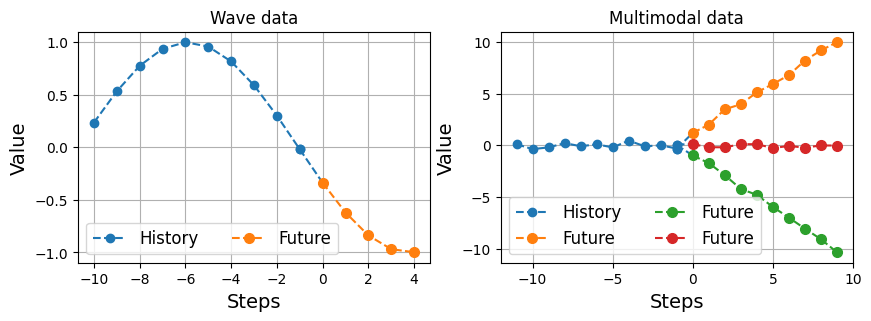

In [30]:
with open(wave_data_training, 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]

index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
plt.plot([-1,0], [history[index][-1], future[index][0]], marker='o', linestyle='--', color="C0")
plt.plot(ts_future, future[index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Wave data")
plt.grid(True)
# plt.show()



with open(wave_data_multimodal, 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]


index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.subplot(1,2,2)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
for i in range(3):
    plt.plot([-1,0], [history[i*100 + index][-1], future[i*100 + index][0]], marker='o', linestyle='--', color="C0")
    plt.plot(ts_future, future[i*100 + index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Multimodal data")
plt.grid(True)
plt.show()


## Regression with sinusoidal trajectories

In this problem, you will learn a regular MLP to regress on sinusoidal data

In [31]:
# feel free to poke around the data
train_data = hw1_helper.TrajectoryData(wave_data_training)
test_data = hw1_helper.TrajectoryData(wave_data_test)

history_length = 10
future_length = 5
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 10000 examples
Test set has 500 examples


### Simple MLP predictor

In [32]:
# Define a simple MLP model
class MLP(torch.nn.Module):
    def __init__(self, history_length, future_length, hidden_size=32):
        super(MLP, self).__init__()
        
        # TODO: construct MLP network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(history_length, hidden_size),  # First layer
            torch.nn.ReLU(),                               # Activation function
            torch.nn.Linear(hidden_size, future_length)   # Second layer
        )
    
    def forward(self, x):
        return self.model(x)



In [33]:
hidden_size = 8
history_length = 10
future_length = 5

model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 30
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [34]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)


Epoch [1/30], Step [0/313], Loss: 0.5543
Epoch [1/30], Step [20/313], Loss: 0.6179
Epoch [1/30], Step [40/313], Loss: 0.4755
Epoch [1/30], Step [60/313], Loss: 0.4204
Epoch [1/30], Step [80/313], Loss: 0.3078
Epoch [1/30], Step [100/313], Loss: 0.3863
Epoch [1/30], Step [120/313], Loss: 0.3137
Epoch [1/30], Step [140/313], Loss: 0.2738
Epoch [1/30], Step [160/313], Loss: 0.2040
Epoch [1/30], Step [180/313], Loss: 0.2240
Epoch [1/30], Step [200/313], Loss: 0.2782
Epoch [1/30], Step [220/313], Loss: 0.1968
Epoch [1/30], Step [240/313], Loss: 0.2441
Epoch [1/30], Step [260/313], Loss: 0.1774
Epoch [1/30], Step [280/313], Loss: 0.1839
Epoch [1/30], Step [300/313], Loss: 0.1587
Epoch 1 completed with average loss: 0.3048
Epoch [2/30], Step [0/313], Loss: 0.1354
Epoch [2/30], Step [20/313], Loss: 0.1293
Epoch [2/30], Step [40/313], Loss: 0.1466
Epoch [2/30], Step [60/313], Loss: 0.0985
Epoch [2/30], Step [80/313], Loss: 0.1283
Epoch [2/30], Step [100/313], Loss: 0.1189
Epoch [2/30], Step [12

In [35]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
   
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-11, 5]
ylims = [-2,2]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0013


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor

In [36]:
    
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=1 ):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # HINT: Use Pytorch built-in functions for LSTM and Linear layers.
        # HINT: batch dimension is dim=0
        
        # TODO: Define encoder LSTM.
        self.encoder = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        ############################
        
        # TODO: Define decoder LSTM
        self.decoder = torch.nn.LSTM(output_dim, hidden_dim, 
                                      num_layers, 
                                      batch_first=True)
        ############################

        
        #TODO: Define linear project from hidden_dim to output_dim
        self.projection = torch.nn.Linear(hidden_dim, output_dim)
        ############################

        
        


    def forward(self, x, t_max, y=None, prob=1.):
        """
        Forward pass of the LSTM model.
        x: The input sequence [batch_size, seq_len, input_dim]
        t_max: maximum time steps to unroll
        y: The target sequence for teacher forcing (optional, used if teacher forcing is applied) [batch_size, t_max, output_dim]
        prob: Probability to apply teacher forcing (0 to 1). 1 means 100% teacher forcing, 
        """
        
        # making sure x and y is the appropriate size.
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        if y is not None and len(y.shape) == 2:
            y = y.unsqueeze(-1)
        
        _, (h_n, c_n) = self.encoder(x)
        batch_size = x.size(0)
        decoder_input = torch.zeros(batch_size, 1, 
self.output_dim).to(x.device)
        ys = [] # collect outputs
        for t in range(t_max):
            out, (h_n, c_n) = self.decoder(decoder_input, (h_n, c_n))
            out = self.projection(out)  # Project hidden state to output
            # Collect the output
            ys.append(out)
        
            if y is not None and torch.rand(1).item() < prob:
                decoder_input = y[:, t].unsqueeze(1)  # use ground truth if teacher forcing
            else:
                decoder_input = out  # otherwise, use model's own prediction
        return torch.cat(ys, dim=1)  # Return predictions as a sequence
        
        # return ys # [batch_size, ts_max, output_dim]


In [37]:
hidden_size = 4
future_length = 5
input_size = 1
output_size = 1

model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
prob = 0.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


def prob_schedule(i):
    return 1 - jax.nn.sigmoid(20 * (i - 0.5)).item()



In [38]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    prob = prob_schedule((epoch + 1)/num_epochs)
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output.squeeze(-1), target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/313], Loss: 1.0933
Epoch [1/10], Step [100/313], Loss: 0.4196
Epoch [1/10], Step [200/313], Loss: 0.3001
Epoch [1/10], Step [300/313], Loss: 0.1563
Epoch 1 completed with average loss: 0.4319
Epoch [2/10], Step [0/313], Loss: 0.1810
Epoch [2/10], Step [100/313], Loss: 0.1096
Epoch [2/10], Step [200/313], Loss: 0.0846
Epoch [2/10], Step [300/313], Loss: 0.0700
Epoch 2 completed with average loss: 0.0949
Epoch [3/10], Step [0/313], Loss: 0.0561
Epoch [3/10], Step [100/313], Loss: 0.0558
Epoch [3/10], Step [200/313], Loss: 0.0407
Epoch [3/10], Step [300/313], Loss: 0.0392
Epoch 3 completed with average loss: 0.0497
Epoch [4/10], Step [0/313], Loss: 0.0592
Epoch [4/10], Step [100/313], Loss: 0.0361
Epoch [4/10], Step [200/313], Loss: 0.0150
Epoch [4/10], Step [300/313], Loss: 0.0164
Epoch 4 completed with average loss: 0.0298
Epoch [5/10], Step [0/313], Loss: 0.0218
Epoch [5/10], Step [100/313], Loss: 0.0166
Epoch [5/10], Step [200/313], Loss: 0.0355
Epoch [5/10], Ste

In [39]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction.squeeze(-1), future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# try with different prediction horizons
prediction_horizon = 5
prediction = model(history, prediction_horizon).squeeze(-1)
print(prediction.size())


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, prediction_horizon + 2]
ylims = [-5,5]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0121
torch.Size([500, 5])


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

## Regression on multimodal data

Now we repeat the same steps but with data where the future has multimodal outcome. 

In [40]:
# load multimodal data
train_data = hw1_helper.TrajectoryData("D:/AA598-aut24/homework/data/hw1/multimodal_data_train.pickle")
test_data = hw1_helper.TrajectoryData("D:/AA598-aut24/homework/data/hw1/multimodal_data_test.pickle")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Simple MLP predictor (multimodal data)

In [41]:

hidden_size = 32
# You should be able to use your MLP class
model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


In [42]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)

Epoch [1/10], Step [0/469], Loss: 29.0598
Epoch [1/10], Step [20/469], Loss: 30.1424
Epoch [1/10], Step [40/469], Loss: 27.5789
Epoch [1/10], Step [60/469], Loss: 21.7529
Epoch [1/10], Step [80/469], Loss: 24.0580
Epoch [1/10], Step [100/469], Loss: 23.0704
Epoch [1/10], Step [120/469], Loss: 30.1643
Epoch [1/10], Step [140/469], Loss: 21.6067
Epoch [1/10], Step [160/469], Loss: 27.8188
Epoch [1/10], Step [180/469], Loss: 20.3169
Epoch [1/10], Step [200/469], Loss: 24.1916
Epoch [1/10], Step [220/469], Loss: 27.5627
Epoch [1/10], Step [240/469], Loss: 31.4913
Epoch [1/10], Step [260/469], Loss: 30.2691
Epoch [1/10], Step [280/469], Loss: 25.2499
Epoch [1/10], Step [300/469], Loss: 30.1727
Epoch [1/10], Step [320/469], Loss: 25.1643
Epoch [1/10], Step [340/469], Loss: 33.5015
Epoch [1/10], Step [360/469], Loss: 24.0861
Epoch [1/10], Step [380/469], Loss: 24.2884
Epoch [1/10], Step [400/469], Loss: 30.0097
Epoch [1/10], Step [420/469], Loss: 34.7716
Epoch [1/10], Step [440/469], Loss: 26

In [43]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    print(prediction.size())
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



torch.Size([300, 10])
Test Loss: 25.8971


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor (multimodal data)

In [44]:
hidden_size = 4
# You should be able to use your LSTM class
model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


In [45]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output.squeeze(-1), target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/469], Loss: 24.2553
Epoch [1/10], Step [100/469], Loss: 23.4326
Epoch [1/10], Step [200/469], Loss: 20.5362
Epoch [1/10], Step [300/469], Loss: 25.3439
Epoch [1/10], Step [400/469], Loss: 27.6055
Epoch 1 completed with average loss: 25.7191
Epoch [2/10], Step [0/469], Loss: 28.9500
Epoch [2/10], Step [100/469], Loss: 21.6872
Epoch [2/10], Step [200/469], Loss: 22.9974
Epoch [2/10], Step [300/469], Loss: 27.7254
Epoch [2/10], Step [400/469], Loss: 22.7665
Epoch 2 completed with average loss: 25.7081
Epoch [3/10], Step [0/469], Loss: 25.1607
Epoch [3/10], Step [100/469], Loss: 29.9594
Epoch [3/10], Step [200/469], Loss: 30.0202
Epoch [3/10], Step [300/469], Loss: 24.1953
Epoch [3/10], Step [400/469], Loss: 27.4010
Epoch 3 completed with average loss: 25.7051
Epoch [4/10], Step [0/469], Loss: 19.0265
Epoch [4/10], Step [100/469], Loss: 25.3399
Epoch [4/10], Step [200/469], Loss: 28.8542
Epoch [4/10], Step [300/469], Loss: 26.4577
Epoch [4/10], Step [400/469], Loss: 2

In [46]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction.squeeze(-1), future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# TODO: try with different prediction horizons
prediction_horizon = future_length
prediction = model(history, prediction_horizon).squeeze(-1)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, prediction_horizon + 2]
ylims = [-12, 12]

interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 25.7173


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

## Consider CVAEs

First, define the encoder and decoder. We will consider some simple MLP encoders. Generally, for trajectory data, it's typically more common to use RNNs or transformers, but since we are considering a small toy problem, we just consider MLP for now since it's simpler.


In [47]:

# some simple MLP encoders. For trajectory data, it's typically more common to use RNNs or transformers
class MLPEncoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # TODO: Construct an MLP encoder
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),  # Input layer
            torch.nn.ReLU(),                         # Activation
            torch.nn.Linear(hidden_dim, hidden_dim), 
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim), # Output layer
            torch.nn.ReLU() 
        ) 
        ############################


    def forward(self, x):
        return self.model(x)
    
    
class MLPDecoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPDecoder, self).__init__()
        self.input_dim = input_dim #
        self.output_dim = output_dim #
        self.hidden_dim = hidden_dim #
        
        # TODO: Construct an MLP encoder
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),  # Input layer
            torch.nn.ReLU(),                         # Activation
            torch.nn.Linear(hidden_dim, hidden_dim), #8
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim) # Output layer
        )
        ############################


    def forward(self, x):
        return self.model(x)


# Some helper functions
def repeat_n(ten, n):
    return torch.stack([ten] * n, dim=0)

def beta_schedule(i):
    return jax.nn.sigmoid(20 * (i - 0.5)).item()


In [48]:
train_data = hw1_helper.TrajectoryData("D:/AA598-aut24/homework/data/hw1/multimodal_data_train.pickle")
test_data = hw1_helper.TrajectoryData("D:/AA598-aut24/homework/data/hw1/multimodal_data_test.pickle")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Continuous CVAE

In [49]:
class ContinuousCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior, hidden_dim, future_dim):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior        
        '''
        
        super(ContinuousCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        self.hidden_dim = hidden_dim

        # TODO: Linear layers to project encoder/decoder to mean and logvar
        self.mean_projection_encoder = torch.nn.Linear(hidden_dim, latent_dim)
        self.logvar_projection_encoder = torch.nn.Linear(hidden_dim, latent_dim)
        self.mean_projection_decoder = torch.nn.Linear(future_dim, future_dim)
        self.logvar_projection_decoder = torch.nn.Linear(future_dim, future_dim)
        ############################

        
    def encode_importance(self, x, y):
        '''Computes mean and log(covariance) of q(z|x,y), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of q(z|x,y)
        combined_input = self.importance(torch.cat([x, y], dim=-1)) 
        z_mu = self.mean_projection_encoder(combined_input)
        z_logvar = self.logvar_projection_encoder(combined_input)
        return z_mu, z_logvar
    
    
    def encode_prior(self, x):
        '''Computes mean and log(covariance) of p(z|x), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of p(z|x)
        combined_input= self.prior(x)
        z_mu = self.mean_projection_encoder(combined_input)
        z_logvar = self.logvar_projection_encoder(combined_input)
        
        ############################
        
        return z_mu, z_logvar
    
    
    def reparameterize(self, mu, logvar, n=1):
        '''samples from a normal distributions parameterized by mu and logvar. Uses PyTorch built-in reparameratization trick'''
        
        prob = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(torch.exp(logvar)))
        
        return prob.rsample((n,))
    
    
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        
        # TODO: compute y_mu and y_logvar of p(y|x,z)
        combined_input = self.decoder(torch.cat((x, z), dim=-1))  # Concatenate inputs
        y_mu = self.mean_projection_decoder(combined_input)
        y_logvar = self.logvar_projection_decoder(combined_input)
        
        ############################
        
        return y_mu, y_logvar

    
    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        
        #  get p(z|x,(y))
        if self.training:
            z_mu, z_logvar = self.encode_importance(x, y)
        else:
            z_mu, z_logvar = self.encode_prior(x)
        # sample from p(z|x,(y)) n times
        z = self.reparameterize(z_mu, z_logvar, n)
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z)     
           
        return z_mu, z_logvar, y_mu, y_logvar
    

    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        
        _, _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return self.reparameterize(y_mu, y_logvar, num_samples)

    
    
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with continuous latent space. Optional: beta term that weigh kl divergence term'''
        
        q_mu, q_logvar, y_mu, y_logvar = self(x, y, z_samples) # get parameters for q(z|x,y) and p(y|x,z) where z~q(z|x,y)
        p_mu, p_logvar = self.encode_prior(x) # get parameters for p(z|x)
        
        # construct the distributions
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        q = torch.distributions.MultivariateNormal(loc=q_mu, covariance_matrix=torch.diag_embed(torch.exp(q_logvar)))  # q(z|x,y)
        p = torch.distributions.MultivariateNormal(loc=p_mu, covariance_matrix=torch.diag_embed(torch.exp(p_logvar)))  # p(z|x)
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean() # log likelihood of data 
        kl_div = torch.distributions.kl.kl_divergence(q, p).mean()  # q_z * (log(q_z) - log(p_z))
        
        return loglikelihood + beta * kl_div
        


      

In [50]:
# continuous cvae
# network parameters
latent_dim = 8# size of latent space
history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim+history_length, future_length, dec_dim)

cvae = ContinuousCVAE(latent_dim, encoder, decoder, prior, hidden_dim, future_length)

num_epochs = 10
learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)


batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)



In [51]:
# train model
z_samples = 16
cvae.train()

for epoch in range(num_epochs):
    running_loss = 0
    beta = beta_schedule((epoch + 1)/ num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
    for batch_idx, (history, future) in enumerate(train_dataloader):
        q_mu, q_logvar, y_mu, y_logvar = cvae(history, future)
        p_mu, p_logvar = cvae.encode_prior(history)
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, z_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 143.2705
Epoch [1/10], Step [100/1875], Loss: 27.0946
Epoch [1/10], Step [200/1875], Loss: 26.2901
Epoch [1/10], Step [300/1875], Loss: 23.0532
Epoch [1/10], Step [400/1875], Loss: 24.5301
Epoch [1/10], Step [500/1875], Loss: 22.1898
Epoch [1/10], Step [600/1875], Loss: 20.4216
Epoch [1/10], Step [700/1875], Loss: 24.5985
Epoch [1/10], Step [800/1875], Loss: 15.9032
Epoch [1/10], Step [900/1875], Loss: 12.5660
Epoch [1/10], Step [1000/1875], Loss: 11.5573
Epoch [1/10], Step [1100/1875], Loss: 6.5901
Epoch [1/10], Step [1200/1875], Loss: 5.1497
Epoch [1/10], Step [1300/1875], Loss: 0.0259
Epoch [1/10], Step [1400/1875], Loss: 7.5240
Epoch [1/10], Step [1500/1875], Loss: 1.4012
Epoch [1/10], Step [1600/1875], Loss: 0.2324
Epoch [1/10], Step [1700/1875], Loss: -2.2793
Epoch [1/10], Step [1800/1875], Loss: 0.1611
======= Epoch 1 completed with average loss: 16.1424 =======
Epoch [2/10], Step [0/1875], Loss: -2.9470
Epoch [2/10], Step [100/1875], Loss: -0.

In [52]:
# Visualize prediction on test data

cvae.eval()

num_samples = 8
num_latent_samples = 8

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

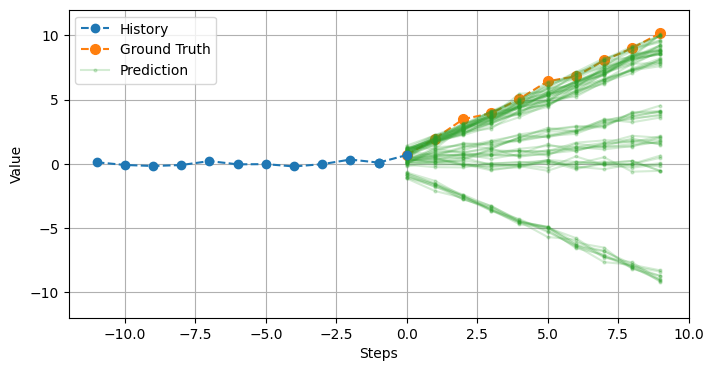

In [53]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)


### Discrete CVAE

In [54]:
class DiscreteCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior, num_categories):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior  
        num_categories: number of categories per latent dimension 
        '''
        
        super(DiscreteCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        self.logits_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim * num_categories)
        self.mean_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.logvar_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.num_categories = num_categories
        
        # Gumbel-softmax reparameterization
        self.gumbel_temperature = 0.1
        
    def encode_importance(self, x, y):
        '''Computes logits of q(z|x,y), assumes one-hot categorical'''
        xy = torch.cat((x, y), dim=-1)
        h = self.importance(xy)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)      
        return z_logits
    
    
    def encode_prior(self, x):
        '''Computes logits of p(z|x), assumes one-hot categorical'''
        h = self.prior(x)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)
        
        return z_logits


    def reparameterize(self, logits):
        '''Sample latent variables using one-hot categorical distributions. Uses gumbel-softmax trick. Pytorch has a bulit-in function for this.'''
        
        return F.gumbel_softmax(logits, tau=self.gumbel_temperature, hard=True) 
        
        
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        xz = torch.cat([x, z], dim=-1)
        g = self.decoder(xz)
        y_mu = self.mean_projection_decoder(g)
        y_logvar = torch.clip(self.logvar_projection_decoder(g), min=-10, max=1)
        
        return y_mu, y_logvar


    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        #  get p(z|x,(y)) and samples from it n times
        if self.training:
            logits = self.encode_importance(x, y) # [bs, latent_dim, num_categories]
            z = self.reparameterize(repeat_n(logits, n)) # [n, bs, latent_dim, num_categories]
        else:
            logits = self.encode_prior(x) # [bs, latent_dim, num_categories]
            z = torch.distributions.OneHotCategorical(logits=logits).sample((n,)) # [n, bs, latent_dim, num_categories]
        z_flatten = z.view(n, -1, self.latent_dim * self.num_categories)  # reshapes to [n, bs, latent_dim * num_categories]
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z_flatten) 

        return logits, y_mu, y_logvar
    
    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return  torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar))).rsample((num_samples,))
        
        
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with discrete latent space. Optional: beta term that weigh kl divergence term'''

        logits, y_mu, y_logvar = self.forward(x, y, z_samples)
        prior_logits = cvae.encode_prior(x)
        
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        
        q_z = F.softmax(logits, dim=-1)  # q(z|x,y)
        log_p_z = F.log_softmax(prior_logits, dim=-1)  # log(p(z|x))
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean()
        kl_div = torch.nn.KLDivLoss(reduction="batchmean")(log_p_z, q_z)
        
        return loglikelihood + beta * kl_div
      

        


In [55]:
# discrete CVAE

history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

latent_dim = 8
num_categories = 8

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim * num_categories + history_length, future_length, dec_dim)

cvae = DiscreteCVAE(latent_dim, encoder, decoder, prior, num_categories)

learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate, weight_decay=1E-2)

batch_size = 8
num_epochs = 10
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [56]:
# train model
cvae.train()
num_latent_samples = 8
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx, (history, future) in enumerate(train_dataloader):
        beta = beta_schedule((epoch+1) / num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, num_latent_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 173.1062
Epoch [1/10], Step [100/1875], Loss: 49.6321
Epoch [1/10], Step [200/1875], Loss: 58.8781
Epoch [1/10], Step [300/1875], Loss: 57.6283
Epoch [1/10], Step [400/1875], Loss: 57.8532
Epoch [1/10], Step [500/1875], Loss: 45.1175
Epoch [1/10], Step [600/1875], Loss: 12.1565
Epoch [1/10], Step [700/1875], Loss: 10.6651
Epoch [1/10], Step [800/1875], Loss: 6.6016
Epoch [1/10], Step [900/1875], Loss: 9.9458
Epoch [1/10], Step [1000/1875], Loss: 6.8796
Epoch [1/10], Step [1100/1875], Loss: 8.1592
Epoch [1/10], Step [1200/1875], Loss: 4.5950
Epoch [1/10], Step [1300/1875], Loss: 4.4730
Epoch [1/10], Step [1400/1875], Loss: 2.8098
Epoch [1/10], Step [1500/1875], Loss: 1.0144
Epoch [1/10], Step [1600/1875], Loss: 3.4832
Epoch [1/10], Step [1700/1875], Loss: 4.0341
Epoch [1/10], Step [1800/1875], Loss: 4.4800
======= Epoch 1 completed with average loss: 23.6594 =======
Epoch [2/10], Step [0/1875], Loss: 3.2498
Epoch [2/10], Step [100/1875], Loss: 1.4368
E

In [57]:
# Visualize prediction on test data

cvae.eval()
num_latent_samples = 32
num_samples = 1

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

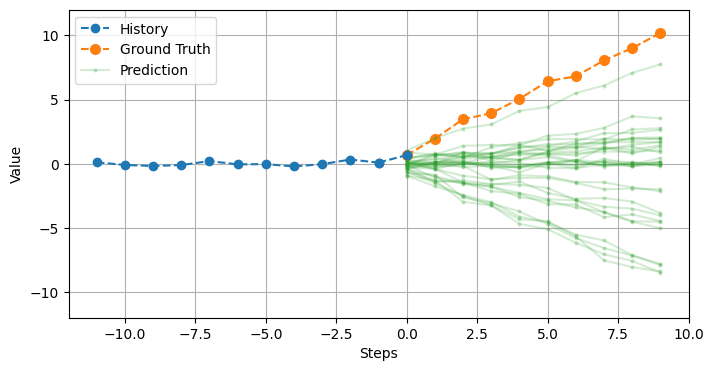

In [58]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)
